In [1]:
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import sys  
import json
sys.path.insert(1, '../../backend/')
from tsne import compute_tsne_series
from utils import normalizeEmbedding

In [2]:
# First, download the Mammoth data from Wang et al. (2021)
# https://github.com/YingfanWang/PaCMAP/blob/master/data/mammoth_3d_50k.json
with open('./mammoth_3d_50k.json', 'r') as f:
    data = json.load(f)
data = np.array(data)

In [3]:
adata = anndata.AnnData(data)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X', metric="euclidean")
sc.tl.louvain(adata, resolution=0.1)

/home/eheiter/Projects/zoomer/backend/backend_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eheiter/Projects/zoomer/backend/backend_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eheiter/Projects/zoomer/backend/ba

# PCA

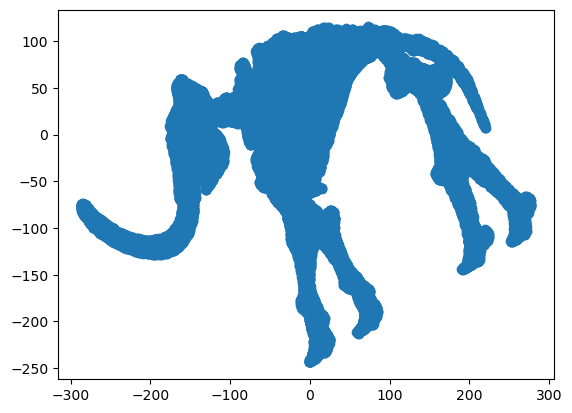

In [4]:
sc.pp.pca(adata, n_comps=2, zero_center=True)
adata.obsm["X_pca"] = -1*adata.obsm["X_pca"]
plt.scatter(adata.obsm['X_pca'][:,0], adata.obsm['X_pca'][:,1])

# UMAP

In [5]:
sc.tl.umap(adata, min_dist=0.2, init_pos="X_pca")

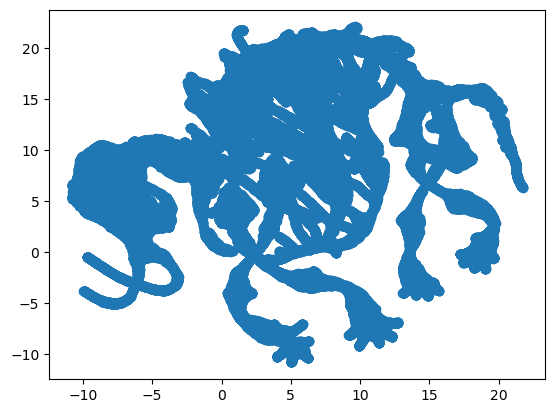

In [6]:
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1])

In [7]:
%%capture
tsne_embs = compute_tsne_series(adata.X, max_exaggeration=5, 
                                 fpath_prefix="./mammoth_tsne", 
                                 hd_metric="euclidean", 
                                 init=adata.obsm["X_pca"])

# Store embeddings in anndata

In [8]:
# tSNE
for name, embedding in tsne_embs.items():
    adata.obsm[name] = normalizeEmbedding(embedding)
    adata.uns[name] = {}

In [9]:
adata.obsm["PCA_0"] = normalizeEmbedding(adata.obsm["X_pca"][:, 0:2])
adata.obsm["UMAP_0"] = normalizeEmbedding(adata.obsm["X_umap"])
adata.uns["UMAP_0"] = {}
adata.uns["PCA_0"] = {}
adata.uns["methods"] = {
    "UMAP": 1,
    "PCA": 1,
    "tSNE": len(tsne_embs),
}

In [10]:
if "X_pca" in adata.obsm_keys():
    del adata.obsm["X_pca"]
if "X_umap" in adata.obsm_keys():
    del adata.obsm["X_umap"]
adata.write(filename="./mammoth.h5ad", compression="gzip")